## Importing Libraries

In [1]:
!pip install -q torchmetrics lightning-utilities seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 961.5/961.5 kB 24.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 83.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 68.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 44.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 103.0 MB/s eta 0:00:00


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision import models
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import torchmetrics
from torchmetrics import Accuracy, ConfusionMatrix
from torchvision.utils import make_grid

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

Using device: cuda


In [3]:
cifar100_mean = (0.5071, 0.4865, 0.4409)
cifar100_std = (0.2673, 0.2564, 0.2762)

transform_train = transforms.Compose([
    transforms.Resize(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(224, padding=4),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(cifar100_mean, cifar100_std)
])

transform_test = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(cifar100_mean, cifar100_std)
])

In [4]:
# ----------------- Load CIFAR-100 Dataset -----------------
train_dataset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform_train)
test_dataset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform_test)
classes = train_dataset.classes


# Train/Val Split
train_set, val_set = torch.utils.data.random_split(train_dataset, [40000, 10000])
train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=64, shuffle=False, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)


100%|██████████| 169M/169M [00:03<00:00, 43.4MB/s]


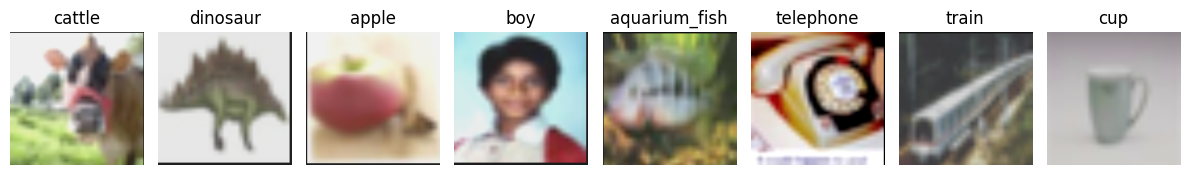

In [5]:
# ----------------- Visualize Sample Images -----------------
def show_sample_images(dataset, classes, n=8):
    plt.figure(figsize=(12, 2))
    for i in range(n):
        img, label = dataset[i]
        img = img * torch.tensor(cifar100_std).view(3,1,1) + torch.tensor(cifar100_mean).view(3,1,1)  # Unnormalize
        plt.subplot(1, n, i+1)
        plt.imshow(img.permute(1, 2, 0))
        plt.title(classes[label])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

show_sample_images(train_dataset, classes)

In [6]:
# ----------------- Load and Fine-Tune ResNet-50 -----------------
model = models.resnet50(weights='IMAGENET1K_V1')

# Freeze all layers
for param in model.parameters():
    param.requires_grad = False

# Unfreeze layer3, layer4 and fc
for layer in [model.layer3, model.layer4, model.fc]:
    for param in layer.parameters():
        param.requires_grad = True

# Replace final FC
model.fc = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(model.fc.in_features, 100)
)

model = model.to(device)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 96.5MB/s]


In [7]:
# ----------------- Loss, Optimizer, Scheduler -----------------
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.0005)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3, verbose=True)


In [8]:
# ----------------- Training & Validation Functions -----------------
def train_one_epoch():
    model.train()
    acc = Accuracy(task='multiclass', num_classes=100).to(device)
    total_loss = 0
    for X, Y in train_loader:
        X, Y = X.to(device), Y.to(device)
        optimizer.zero_grad()
        preds = model(X)
        loss = criterion(preds, Y)
        loss.backward()
        optimizer.step()
        acc.update(preds.argmax(dim=1), Y)
        total_loss += loss.item() * X.size(0)
    return total_loss / len(train_loader.dataset), acc.compute().item()

def validate(loader):
    model.eval()
    acc = Accuracy(task='multiclass', num_classes=100).to(device)
    total_loss = 0
    with torch.no_grad():
        for X, Y in loader:
            X, Y = X.to(device), Y.to(device)
            preds = model(X)
            loss = criterion(preds, Y)
            acc.update(preds.argmax(dim=1), Y)
            total_loss += loss.item() * X.size(0)
    return total_loss / len(loader.dataset), acc.compute().item()

In [9]:
# ----------------- Training Loop -----------------
history = pd.DataFrame()
epochs = 20

for epoch in range(epochs):
    train_loss, train_acc = train_one_epoch()
    val_loss, val_acc = validate(val_loader)
    scheduler.step(val_acc)
    print(f"Epoch {epoch+1}: Train Acc={train_acc:.4f}, Val Acc={val_acc:.4f}")
    history = pd.concat([history, pd.DataFrame({
        'epoch': [epoch],
        'train_loss': [train_loss],
        'train_acc': [train_acc],
        'val_loss': [val_loss],
        'val_acc': [val_acc]
    })], ignore_index=True)

Epoch 1: Train Acc=0.4412, Val Acc=0.5797
Epoch 2: Train Acc=0.6125, Val Acc=0.6358
Epoch 3: Train Acc=0.6805, Val Acc=0.6630
Epoch 4: Train Acc=0.7245, Val Acc=0.6755
Epoch 5: Train Acc=0.7606, Val Acc=0.6951
Epoch 6: Train Acc=0.7887, Val Acc=0.7087
Epoch 7: Train Acc=0.8099, Val Acc=0.7067
Epoch 8: Train Acc=0.8351, Val Acc=0.7146
Epoch 9: Train Acc=0.8504, Val Acc=0.7237
Epoch 10: Train Acc=0.8677, Val Acc=0.7173
Epoch 11: Train Acc=0.8837, Val Acc=0.7206
Epoch 12: Train Acc=0.8964, Val Acc=0.7174
Epoch 13: Train Acc=0.9010, Val Acc=0.7247
Epoch 14: Train Acc=0.9120, Val Acc=0.7246
Epoch 15: Train Acc=0.9198, Val Acc=0.7214
Epoch 16: Train Acc=0.9245, Val Acc=0.7120
Epoch 17: Train Acc=0.9282, Val Acc=0.7343
Epoch 18: Train Acc=0.9369, Val Acc=0.7233
Epoch 19: Train Acc=0.9385, Val Acc=0.7236
Epoch 20: Train Acc=0.9410, Val Acc=0.7209


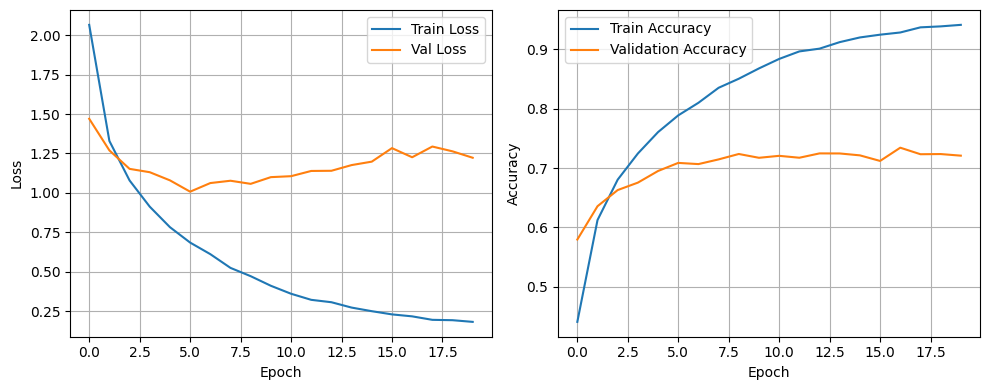

In [10]:
# ----------------- Visualize Metrics -----------------
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history['epoch'], history['train_loss'], label='Train Loss')
plt.plot(history['epoch'], history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(history['epoch'], history['train_acc'], label='Train Accuracy')
plt.plot(history['epoch'], history['val_acc'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

Test Accuracy: 0.7372999787330627


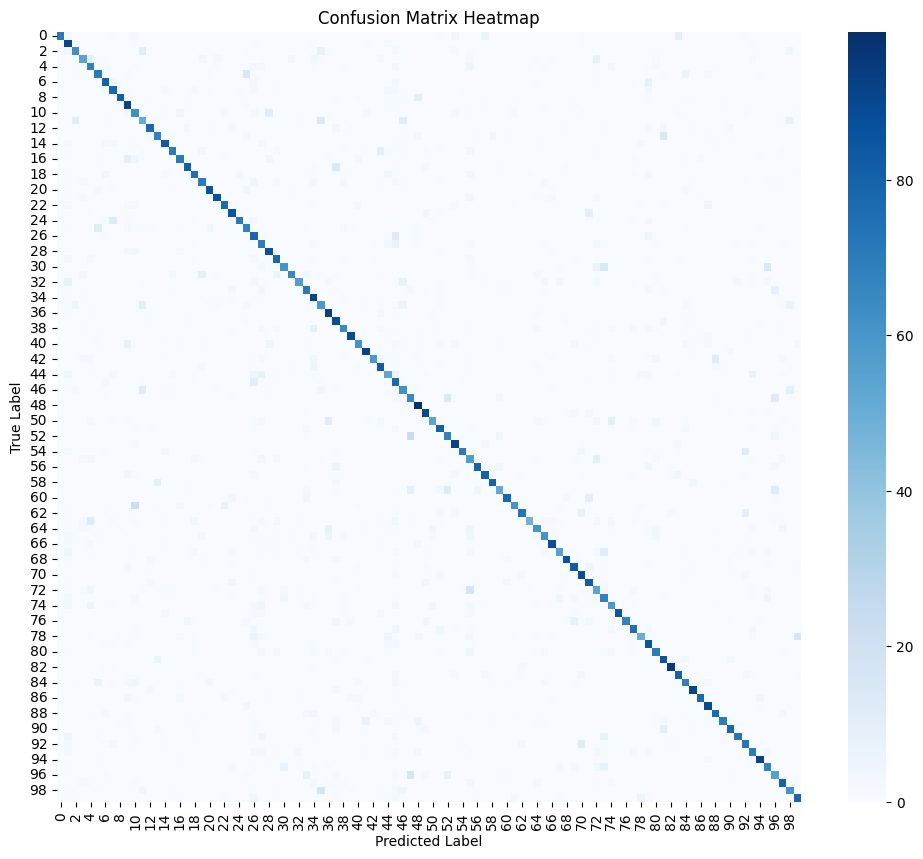

In [11]:
# ----------------- Final Test Evaluation -----------------
model.eval()
test_acc = Accuracy(task='multiclass', num_classes=100)
conf_matrix = ConfusionMatrix(task='multiclass', num_classes=100)

with torch.no_grad():
    for X, Y in test_loader:
        preds = model(X.to(device)).argmax(dim=1)
        test_acc.update(preds.cpu(), Y)
        conf_matrix.update(preds.cpu(), Y)

print("Test Accuracy:", test_acc.compute().item())

plt.figure(figsize=(12,10))
sns.heatmap(conf_matrix.compute().numpy(), cmap="Blues")
plt.title("Confusion Matrix Heatmap")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

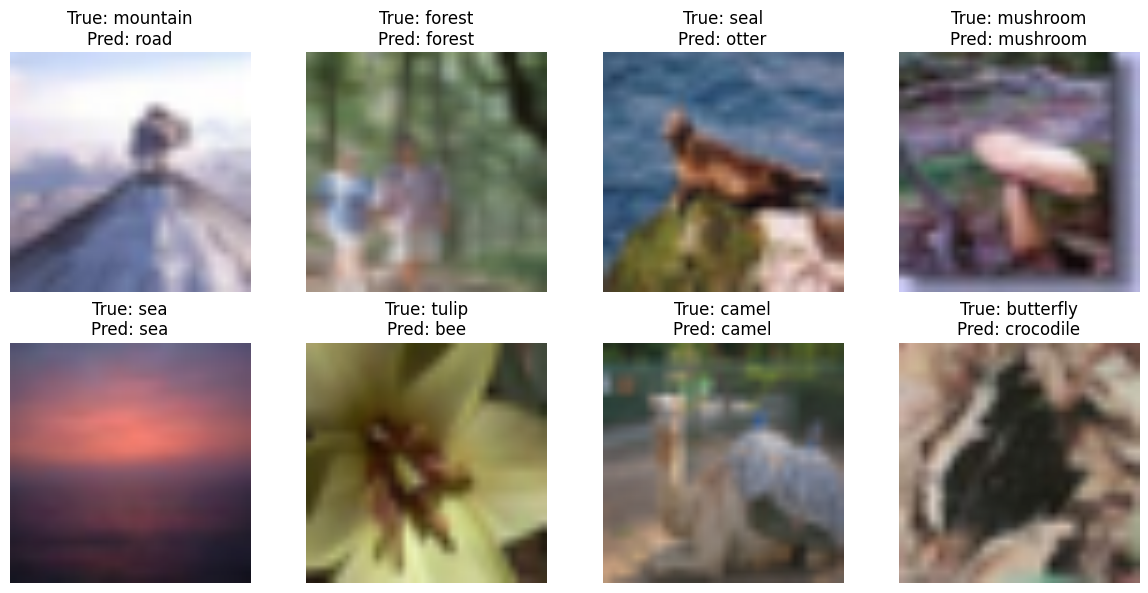

In [12]:
# ----------------- Qualitative Predictions -----------------
fig, axes = plt.subplots(2, 4, figsize=(12,6))
model.eval()
with torch.no_grad():
    for i in range(8):
        img, label = test_dataset[i]
        pred = model(img.unsqueeze(0).to(device)).argmax(dim=1).item()
        img_disp = img * torch.tensor(cifar100_std).view(3,1,1) + torch.tensor(cifar100_mean).view(3,1,1)
        ax = axes[i//4, i%4]
        ax.imshow(img_disp.permute(1,2,0))
        ax.set_title(f"True: {classes[label]}\nPred: {classes[pred]}")
        ax.axis('off')
plt.tight_layout()
plt.show()